In [ ]:
# https://github.com/webis-de/small-text/blob/v1.1.0/examples/notebooks/01-active-learning-for-text-classification-with-small-text-intro.ipynb
# small-text testing of slightly different demo for text classification

In [1]:
%pip install small-text[transformers]==1.1.0  # use "small-text" without "[transformers]" if you want to work on the CPU only

# additional dependencies for this example
%pip install datasets matplotlib seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 178 kB 30.0 MB/s 
     |████████████████████████████████| 4.9 MB 57.9 MB/s 
     |████████████████████████████████| 6.6 MB 55.3 MB/s 
     |████████████████████████████████| 163 kB 78.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 432 kB 33.8 MB/s 
     |████████████████████████████████| 212 kB 63.8 MB/s 
     |████████████████████████████████| 115 kB 6.7 MB/s 
     |████████████████████████████████| 127 kB 64.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [2]:
import datasets
datasets.logging.set_verbosity_error()

# disables the progress bar for notebooks: https://github.com/huggingface/datasets/issues/2651
datasets.logging.get_verbosity = lambda: logging.NOTSET

In [3]:
from matplotlib import rcParams
rcParams.update({'xtick.labelsize': 14, 'ytick.labelsize': 14, 'axes.labelsize': 16})

In [4]:
import torch
import numpy as np

seed = 2022
torch.manual_seed(seed)
np.random.seed(seed)

In [5]:
import logging

raw_dataset = datasets.load_dataset('rotten_tomatoes')
num_classes = np.unique(raw_dataset['train']['label']).shape[0]

print('First 10 training samples:\n')
for i in range(10):
    print(raw_dataset['train']['label'][i], ' ', raw_dataset['train']['text'][i])

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Dataset rotten_tomatoes downloaded and prepared to /root/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

First 10 training samples:

1   the rock is destined to be the 21st century's new " conan " and that he's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .
1   the gorgeously elaborate continuation of " the lord of the rings " trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson's expanded vision of j . r . r . tolkien's middle-earth .
1   effective but too-tepid biopic
1   if you sometimes like to go to the movies to have fun , wasabi is a good place to start .
1   emerges as something rare , an issue movie that's so honest and keenly observed that it doesn't feel like one .
1   the film provides some great insight into the neurotic mindset of all comics -- even those who have reached the absolute top of the game .
1   offers that rare combination of entertainment and education .
1   perhaps no picture ever made has more literally showed that the road to hell is paved with good inten

In [6]:
from transformers import AutoTokenizer

transformer_model_name = 'bert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(
    transformer_model_name
)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [7]:
from small_text import TransformersDataset


train = TransformersDataset.from_arrays(raw_dataset['train']['text'],
                                        raw_dataset['train']['label'],
                                        tokenizer,
                                        max_length=60)
test = TransformersDataset.from_arrays(raw_dataset['test']['text'], 
                                       raw_dataset['test']['label'],
                                       tokenizer,
                                       max_length=60)

/usr/local/lib/python3.7/dist-packages/small_text/utils/annotations.py:69: ExperimentalWarning: The function from_arrays is experimental and maybe subject to change soon.
  ExperimentalWarning)
/usr/local/lib/python3.7/dist-packages/small_text/data/datasets.py:29: UserWarning: Passing target_labels=None is discouraged as it can lead to unintended results in combination with indexing and cloning. Moreover, explicit target labels might be required in the next major version.
  warnings.warn('Passing target_labels=None is discouraged as it can lead to '


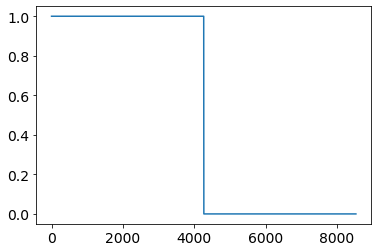

In [16]:
# dkxiao own testing section
import matplotlib.pyplot as plt
plt.plot(raw_dataset['train']['label']) # labels are evenly distributed between label 1 and 0
# does active learner determine the probability based on the labels?

In [ ]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_pred_test, test.y)

In [ ]:
from small_text import (
    PoolBasedActiveLearner,
    PredictionEntropy,
    TransformerBasedClassificationFactory,
    TransformerModelArguments,
    random_initialization_balanced
)


# simulates an initial labeling to warm-start the active learning process
def initialize_active_learner(active_learner, y_train):

    indices_initial = random_initialization_balanced(y_train, n_samples=20)
    active_learner.initialize_data(indices_initial, y_train[indices_initial])

    return indices_initial



transformer_model = TransformerModelArguments(transformer_model_name)
clf_factory = TransformerBasedClassificationFactory(transformer_model, 
                                                    num_classes, 
                                                    kwargs=dict({'device': 'cuda', 
                                                                 'mini_batch_size': 32,
                                                                 'class_weight': 'balanced'
                                                                }))
query_strategy = PredictionEntropy()

active_learner = PoolBasedActiveLearner(clf_factory, query_strategy, train)
indices_labeled = initialize_active_learner(active_learner, train.y)

In [ ]:
from sklearn.metrics import accuracy_score


num_queries = 10


def evaluate(active_learner, train, test):
    y_pred = active_learner.classifier.predict(train)
    y_pred_test = active_learner.classifier.predict(test)
    
    test_acc = accuracy_score(y_pred_test, test.y)

    print('Train accuracy: {:.2f}'.format(accuracy_score(y_pred, train.y)))
    print('Test accuracy: {:.2f}'.format(test_acc))
    
    return test_acc


results = []
results.append(evaluate(active_learner, train[indices_labeled], test))

    
for i in range(num_queries):
    # ...where each iteration consists of labelling 20 samples
    indices_queried = active_learner.query(num_samples=20)

    # Simulate user interaction here. Replace this for real-world usage.
    y = train.y[indices_queried]

    # Return the labels for the current query to the active learner.
    active_learner.update(y)

    indices_labeled = np.concatenate([indices_queried, indices_labeled])
    
    print('---------------')
    print(f'Iteration #{i} ({len(indices_labeled)} samples)')
    results.append(evaluate(active_learner, train[indices_labeled], test))

In [ ]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))
ax = plt.axes()

data = np.vstack((np.arange(num_queries+1), np.array(results)))
sns.lineplot(x=0, y=1, data=data)

plt.xlabel('number of queries', labelpad=15)
plt.ylabel('test accuracy', labelpad=25)

sns.despine()

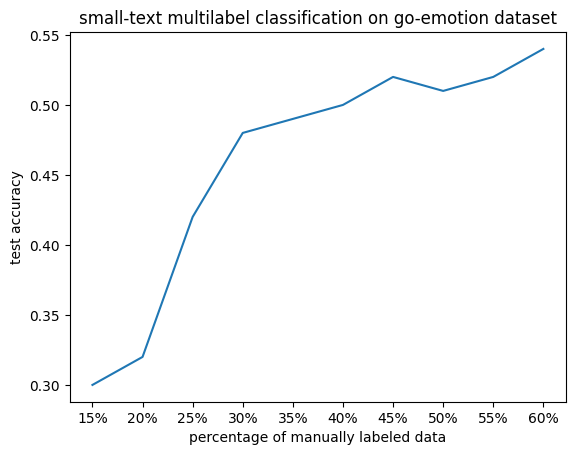

In [22]:
# Plot results from small-text multilabel-classification example 
# go-emotions dataset (reduced to 10000/1000/1000)
# query strategy: prediction entropy 
# training time: 1h 50min

import matplotlib.pyplot as plt

train_accuracy = [0.39, 0.36, 0.51, 0.59, 0.56, 0.63, 0.63, 0.59, 0.68, 0.73]
test_accuracy = [0.30, 0.32, 0.42, 0.48, 0.49, 0.50, 0.52, 0.51, 0.52, 0.54]
label_iteration = [1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000]
label_iteration = list(map(lambda x: str(int(x/100)) + "%", label_iteration))

plt.plot(label_iteration, test_accuracy)
# plt.plot(label_iteration, train_accuracy)
plt.title("small-text multilabel classification on go-emotion dataset")
plt.xlabel('percentage of manually labeled data')
plt.ylabel('test accuracy')
plt.show()